## Part 1: Experiment interaction with Gtihub MCP Server

#### Example: Run GitHub MCP server locally in Docker
The following code loads environment settings, spins up an OpenAI chat client, and launches GitHub’s MCP server inside Docker so the agent can call GitHub tools.

dotenv pulls in API keys and MCP settings from .env.
OpenAIChatClient is configured with your custom base URL/model so every MCP call uses that backend.

The MCP tool definition wraps docker run; it injects the GitHub PAT plus the list of toolsets the server should expose.
await github_mcp.connect() starts the Docker container and establishes the socket so subsequent ChatAgent runs can invoke GitHub functions (repos, PRs, issues, etc.) through the MCP layer.

In [ ]:
from agent_framework.openai import OpenAIChatClient
from agent_framework import MCPStdioTool, ChatAgent
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")
chat_client = OpenAIChatClient(api_key=os.getenv("OPENAI_API_KEY"), model_id=os.getenv("MODEL_ID"))
GITHUB_TOKEN = os.getenv("GITHUB_PAT_TOKEN")
GITHUB_REPO = os.getenv("GITHUB_REPO")
GITHUB_OWNER = os.getenv("GITHUB_OWNER")
TARGET_PR_NUMBER = os.getenv("TARGET_PR_NUMBER")
# Specify the toolsets we want. There are far more, but only these are needed for this example.
# And we don't want to bloat the agent's context with unnecessary tools.
toolsets = "context,pull_requests" 


github_mcp = MCPStdioTool(
    name="GitHubMCP",
    command="docker",
    args=[
        "run", "-i", "--rm",
        "-e", f"GITHUB_PERSONAL_ACCESS_TOKEN={GITHUB_TOKEN}", 
        f"-e", f"GITHUB_TOOLSETS={toolsets}",
        "ghcr.io/github/github-mcp-server"
    ],
    chat_client=chat_client,
)
await github_mcp.connect()
print("GitHub MCP connected")



GitHub MCP connected


### Example: List all available github mcp server tools

In [2]:
print(f"Functions available in GitHub MCP ({len(github_mcp.functions)}):")
for elem in github_mcp.functions:
    print(elem.name)

Functions available in GitHub MCP (13):
add_comment_to_pending_review
create_pull_request
get_me
get_team_members
get_teams
list_pull_requests
merge_pull_request
pull_request_read
pull_request_review_write
request_copilot_review
search_pull_requests
update_pull_request
update_pull_request_branch


### Example: Write comment to a pull request using Github's MCP server

This block wires the GitHub MCP tools into a task‑specific agent that leaves a review comment on a pull request.

all_tools = [*github_mcp.functions] expands every capability exposed by the connected MCP server (issues, PR reviews, etc.).

The instructions string plays system prompt: the agent must operate only on iuf26/workshop-project-detect-secrets-in-repo and reply with SUCCESS or FAILURE.

ChatAgent binds those instructions, the shared chat_client, and the MCP tool list into a named agent (ResearchAgent).

The await agent.run(...) call triggers one conversational turn where the agent visits PR #1, starts a review if needed, and posts the requested comment on leaky_sample.py line 6; the printed result is just SUCCESS or FAILURE + reason.

In [ ]:
all_tools = [*github_mcp.functions]
instructions = f"""
You are a helpful assistant that helps me write comments to the '{GITHUB_REPO}' github repository with OWNER '{GITHUB_OWNER}'. 
As a response only return 'SUCCESS' if operation succeeded and otherwise return 'FAILURE' and reason for failure.
If you get errors while attempting to write the comment, please attempt first to work around it (unless there is no way to do so).
"""
agent = ChatAgent(
    chat_client=chat_client,
    instructions=instructions,
    name="ResearchAgent",
    tools=all_tools
 )
result = await agent.run(
    "I would like to add the 'please remove this secret number 12 9 November'" \
    " comment to the pull request number 1 to the 'leaky_sample.py' file at line number 12. " \
    "If there is no review started for the viewer please do create it.")
print(result)


### Example: Retrieve all files from a PR using GitHub MCP server

In [ ]:
from domain.models import PRFileList
all_tools = [*github_mcp.functions]
instructions = f"""
You are a helpful assistant. Retrieve all files included in an open pull request from the GitHub repository '{GITHUB_OWNER}/{GITHUB_REPO}'.
Respond only with a list of direct links (URLs) to the files changed or added in the pull request — no explanations or additional text.
"""
github_pr_agent = ChatAgent(
    chat_client=chat_client,
    instructions=instructions,
    name="PullRequestAgent",
    tools=all_tools
 )
result = await github_pr_agent.run("Get me all the files involved in the PR with number 1.")
print(result)


https://github.com/flaviusfetean/workshop-detect_secrets/blob/feat/add_secrets/leaky_sample.py


We can also add Structured output to the chat client by specifying the desired output format in order to have a readily available object that we can use without parsing it ourselves, and we will know for sure that the structure is correct because it will be reinforced by the OpenAI server

In [ ]:
from domain.models import PRFileList
instructions = f"""
You are a helpful assistant. Retrieve all files included in the open pull request from the GitHub repository '{GITHUB_OWNER}/{GITHUB_REPO}'.
"""
github_pr_agent = ChatAgent(
    chat_client=chat_client,
    instructions=instructions,
    name="PullRequestAgent",
    tools=all_tools, 
    response_format=PRFileList
 )
# Extract with structured output
result_structured = await github_pr_agent.run(
    "Get me all the files involved in the PR with number 1.",
    response_model=PRFileList
)
print("Structured result:", result_structured.value)


Structured result: files=[PRFileInfo(source_file='leaky_sample.py', pull_request_number='1', source_branch='feat/add_secrets', repo='workshop-detect_secrets', repo_owner='flaviusfetean')]


## Part 2: Implement agentic workflow

### Define Chunk processing research agent

### Split the files in chunk
First, we need a method to split the file in the PR into chunks, as we don't want to fit an entire file into the context of the Agent.

We can define the chunks whatever we like. Here, we define a chunk as a continuous block of 10 lines.
But ideally, we want to keep logic intact, so a better approach would be to use more complex logic and not break multi-line statements or functions.

In [ ]:
from pathlib import Path
from typing import List, Dict

def split_file_by_newlines(
    file_path: str,
    newlines_per_chunk: int,
    pull_request_number: str = "",
    repo: str = "",
    repo_owner: str = "",
) -> List[Dict]:
    """ 
    Split a text file into chunks containing a fixed number of newline separators.
    - Normalizes all line endings to '\n' first.
    - `original_lines_interval` is 1-based and inclusive.
    - If the last chunk has fewer lines (fewer '\n' separators), it's still included.
    """

    if "http" in file_path:
        # If it's a web URL and not a local file, fetch the content
        import requests
        
        filepath_github_raw = file_path.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

        r = requests.get(filepath_github_raw)
        r.raise_for_status()

        text = r.text.replace("\r\n", "\n").replace("\r", "\n")
        original_file = file_path.split("/")[-1]
    else:
        p = Path(file_path)
        original_file = p.name

        # Normalize all newlines to '\n' to ensure consistent splitting
        text = p.read_text(encoding="utf-8", errors="replace").replace("\r\n", "\n").replace("\r", "\n")

    # Split strictly by '\n'
    lines = text.split("\n")  # newline characters are removed by split
    total_lines = len(lines)

    chunks: List[Dict] = []

    # Step through in blocks of `newlines_per_chunk` lines
    for i in range(0, total_lines, newlines_per_chunk):
        block = lines[i : i + newlines_per_chunk]
        if not block:
            continue

        # Reconstruct the chunk string with '\n' between lines.
        # IMPORTANT: we DO NOT append a trailing '\n' at the end of the chunk.
        chunk_text = "\n".join(block)

        # 1-based line numbers for the original interval
        start_line = i + 1
        end_line = i + len(block)

        chunks.append({
            "chunk": chunk_text,
            "original_lines_interval": [start_line, end_line],
            "original_file": original_file,
            "pull_request_number": pull_request_number,
            "repo": repo,
            "repo_owner": repo_owner,
        })

    return chunks

In [8]:
input_test_chunks = split_file_by_newlines("samples/leaky_sample.py",10,"1",repo="workshop-detect-secrets-in-repo",repo_owner="iuf26")

In [4]:
input_test_chunks_from_url = split_file_by_newlines("https://raw.githubusercontent.com/flaviusfetean/workshop-detect_secrets/feat/add_secrets/leaky_sample.py",10,"1",repo="workshop-detect_secrets",repo_owner="flaviusfetean")

# leaky_sample.py
# ⚠️ FAKE CREDENTIALS FOR TESTING ONLY. NONE OF THESE WORK.
# This file intentionally contains strings that *look like* secrets so you can
# test detectors, LLMs, and CI scanners. Do


In [5]:
import hashlib
import uuid

from domain.models import TextChunk

NAMESPACE = uuid.UUID("876de125-4386-442b-9e88-d40dfbbb301d")  # pick once & keep
def stable_uuid(s: str) -> str:
    s = s.strip().lower()  # normalize to avoid accidental mismatches
    return str(uuid.uuid5(NAMESPACE, s))

def shard_for_chunk(chunk: TextChunk, total_agents: int) -> int:
    """
    Pick which worker (0..total_agents-1) should handle this chunk.

    How it works (in plain words):
    - Build a key from the file name and line range (e.g., "app.py|120|180").
    - Hash that key with SHA-256 (gives a big, stable number).
    - Take that number modulo total_agents to get a shard index.

    Inputs:
    - chunk: has `source_file: str` and `line_span: (start:int, end:int)`.
    - total_agents: number of workers; must be >= 1.

    Guarantees:
    - Same chunk → same shard index (deterministic).
    - Result r is an int with 0 <= r < total_agents.

    Example:
    >> shard_for_chunk(TextChunk(source_file="a.py", line_span=(10, 30)), total_agents=3)
    2
    """
    h = hashlib.sha256(f"{chunk.source_file}|{chunk.line_span}".encode()).digest()
    return int.from_bytes(h[:4], "big") % total_agents

#### Perform necessary imports

In [6]:
import json
import asyncio
from agent_framework import (
    handler, Executor, ChatAgent, 
    ExecutorInvokedEvent, ExecutorCompletedEvent,
    WorkflowEvent, WorkflowBuilder, WorkflowContext, 
)
from agent_framework.openai import OpenAIChatClient

from domain.models import (
    TextChunk, PRFileList, PRFileInfo, LineComment, 
    SecretsDetectorExecutorResponse, EmptySecretsDetectorExecutorResponseFactory, 
)
DETECTED_SECRETS_RESULT_KEY = "detected_secrets"

class CustomResponseEvent(WorkflowEvent):
    def __init__(self, result: list[SecretsDetectorExecutorResponse]):
        super().__init__(result)

#### Define the Executors
We will begin by defining the executor which actually performs secret detection.

In [ ]:
class SecretsDetectorExec(Executor):
    agent: ChatAgent
    agent_instruction = """
        <instruction role="system">
        You are a code-secrets detector. Given a text CHUNK (with "\n" newlines) and its original line interval [START, END], return only a JSON array of findings. Flag lines that contain likely secrets (API keys/tokens, private keys, passwords, connection strings with creds, service-account JSON fields, auth headers) or PII (names paired with email/phone/IDs). Be precise; if unsure, don't flag. Ignore obvious placeholders.
        </instruction>
        <schema>
        Output exactly:
        [
        { "line_number": <int original line>, "comment": "<types comma-separated>. Please remove." }
        ]
        Return [] if nothing is found. No extra text.
        </schema>
        <procedure>
        1) Split CHUNK by "\n".
        2) For each line i (1-based), assess for secrets/PII using field names and context (e.g., "api_key", "token", "password", "private_key", DSN with user:pass, "Authorization: Bearer ...", service-account fields like private_key_id/private_key).
        3) If flagged, compute original line_number = START + i - 1.
        4) Emit JSON as per <schema>, comments short, no code excerpts.
        </procedure>
        <example>
        INPUT:
        START=4, END=7
        CHUNK:
        print("ok")
        "private_key_id": "f4f3c2e1d0b9a8f7e6d5c4b3a2918171",
        print("done")

        OUTPUT:
        [
        { "line_number": 5, "comment": "Private key identifier. Please remove." }
        ]
        </example>
    """

    def __init__(self, chat_client: OpenAIChatClient,  my_shard: int, total_agents: int, id: str = "secrets detector"):
        # Define the inner agent which will do the secrets detection
        #TODO: Here comes the code ;)
        return
    
    def create_prompt_from_chunk(self, chunk: TextChunk):
        prompt = f"""
            Please investigate and detect secrets existent in the chunk taken from the line intervals of the file {chunk.source_file}.
            INPUT
            START={chunk.line_span[0]}, END={chunk.line_span[1]}
            CHUNK:
            {chunk.text}
        """
        return prompt

    
    @handler
    async def run(self, chunk: TextChunk,ctx: WorkflowContext[SecretsDetectorExecutorResponse]) -> None:
        #TODO: Here comes the code ;)
        return

We then define the executor which gathers the PR code and sends it to the secrets detector

In [ ]:
class ChunksExporterExec(Executor):
    agent_instructions = f"""
        You are a helpful assistant. Retrieve all files included in an open pull request from the GitHub repository '{GITHUB_OWNER}/{GITHUB_REPO}'.
        Respond only with a list of direct links (URLs) to the files changed or added in the pull request along with the necessary extra information (owner, repo, branch).
        """

    def __init__(self, id, github_mcp_server, chat_client: OpenAIChatClient):
        #TODO: Here comes the code ;)
        return

    @handler
    async def run(self, _: str,ctx: WorkflowContext[TextChunk]) -> None:
        #TODO: Here comes the code ;)
        return

We then define the executor which will aggregate the results of the findings and make the actual calls to post the comments on the PR

In [ ]:
class ChunksAgregatorExec(Executor):

    def __init__(self, id, github_mcp_server):
         #TODO: Here comes the code ;)
         return
    
    async def _call_github_mcp_client(self, detected_secret: SecretsDetectorExecutorResponse, line_comment: LineComment):
        #TODO: Here comes the code ;)
        return

    @handler
    async def run(self, detected_secrets: list[SecretsDetectorExecutorResponse] ,ctx: WorkflowContext[None]) -> None:
        #TODO: Here comes the code ;)
        return
        

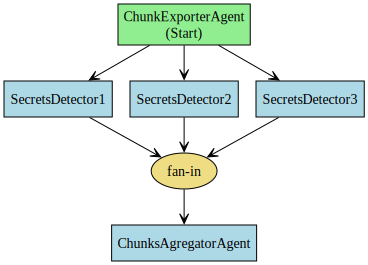

In [ ]:
from agent_framework import WorkflowViz
#TODO: Here comes the code ;)
viz = WorkflowViz(workflow)
try:
    from graphviz import Source
    from IPython.display import display
    src = Source(viz.to_digraph())
    display(src)
except Exception as e:
    print(f"Error rendering diagram: {e}")
    print(viz.to_mermaid())


#### Visualize workflow

In [ ]:
async for event in workflow.run_stream(""):
    #TODO: Here comes the code ;)
    return
        

Files in PR: ['leaky_sample.py']
# leaky_sample.py
# ⚠️ FAKE CREDENTIALS FOR TESTING ONLY. NONE OF THESE WORK.
# This file intentionally contains strings that *look like* secrets so you can
# test detectors, LLMs, and CI scanners. Do
Starting ChunkExporterAgent
Completed ChunkExporterAgent: None
Starting SecretsDetector1
Completed SecretsDetector1: None
Starting SecretsDetector2
Starting SecretsDetector3
Completed SecretsDetector3: None
Completed SecretsDetector2: None
Starting SecretsDetector1
Completed SecretsDetector1: None
Starting SecretsDetector2
Completed SecretsDetector2: None
Starting SecretsDetector3
Completed SecretsDetector3: None
Starting SecretsDetector1
Completed SecretsDetector1: None
Starting SecretsDetector2
Completed SecretsDetector2: None
Starting SecretsDetector3
Completed SecretsDetector3: None
Starting SecretsDetector1
Completed SecretsDetector1: None
Starting SecretsDetector2
Starting SecretsDetector3
Completed SecretsDetector3: None
Completed SecretsDetector2: 